
Поиск url1 → url2:

Найден путь (url1 → url2):
 => https://ru.wikipedia.org/wiki/Статистика
 => https://ru.wikipedia.org/wiki/Выборка


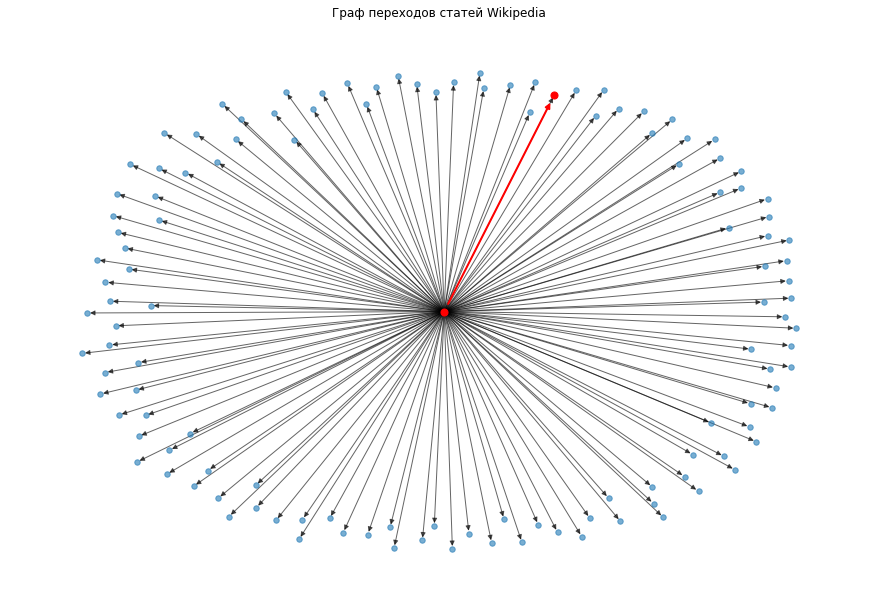


Поиск url2 → url1:

Найден путь (url2 → url1):
 => https://ru.wikipedia.org/wiki/Выборка
 => https://ru.wikipedia.org/wiki/Генеральная_совокупность
 => https://ru.wikipedia.org/wiki/Статистика


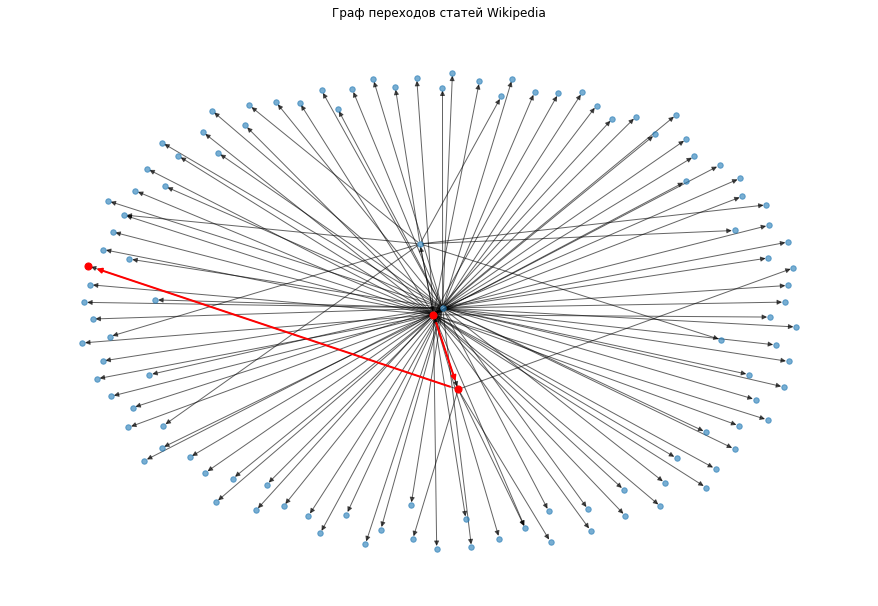

In [1]:
#!pip install networkx matplotlib beautifulsoup4 requests #если нужно
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, unquote
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt

# параметры можно поменять, чтобы с клавиатуры вводилось
url1 = "https://ru.wikipedia.org/wiki/Статистика"
url2 = "https://ru.wikipedia.org/wiki/Выборка"
rate_limit = 10 #количество подключений
max_depth = 5 # рукопожатий

# Эвристика приоритета
def similarity_score(link_title, target_title):
    w1 = set(link_title.lower().split('_'))
    w2 = set(target_title.lower().split('_'))
    return len(w1 & w2)

def prioritized_links(links, target_url):
    target_title = target_url.rsplit('/', 1)[-1]
    return sorted(links, key=lambda link: -similarity_score(link.rsplit('/', 1)[-1], target_title))

# парсинг ссылок
def extract_links(url, lang_domain, connections_made, limit):
    if connections_made[0] >= limit:
        return set()
    try:
        response = requests.get(url, timeout=10)
        connections_made[0] += 1
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        content = soup.find('div', {'class': 'mw-parser-output'})
        if content:
            for tag in content.find_all('a', href=True):
                href = tag['href']
                if href.startswith('/wiki/') and ':' not in href:
                    full_url = urljoin(f"https://{lang_domain}", href)
                    if urlparse(full_url).netloc == lang_domain:
                        links.add(unquote(full_url))
        references = soup.find_all('ol', class_='references') + soup.find_all('div', class_='reflist')
        for ref in references:
            for tag in ref.find_all('a', href=True):
                href = tag['href']
                if href.startswith('/wiki/') and ':' not in href:
                    full_url = urljoin(f"https://{lang_domain}", href)
                    if urlparse(full_url).netloc == lang_domain:
                        links.add(unquote(full_url))
        return links
    except Exception as e:
        print(f"Ошибка при загрузке {url}: {e}")
        return set()

#BFS + приоритет + early check + graph
def bfs_graph(start_url, target_url, max_depth, limit, graph):
    lang_domain = urlparse(start_url).netloc
    start_url = unquote(start_url)
    target_url = unquote(target_url)

    visited = set()
    queue = deque([(start_url, [start_url])])
    connections_made = [0]

    while queue:
        current_url, path = queue.popleft()
        if current_url in visited:
            continue
        visited.add(current_url)

        if current_url == target_url:
            return path

        if len(path) > max_depth:
            continue

        links = extract_links(current_url, lang_domain, connections_made, limit)

        if connections_made[0] >= limit:
            print(f"Превышен лимит подключений ({limit})")
            return None

        # Проверка, есть ли целевая ссылка, экономим подключения
        if target_url in links:
            for link in links:
                graph.add_edge(current_url, link)
            return path + [target_url]

        # граф
        for link in links:
            graph.add_edge(current_url, link)

        #Приоритетный обход
        prioritized = prioritized_links(links, target_url)
        for link in prioritized:
            if link not in visited:
                queue.append((link, path + [link]))

    return None

# Визуализация графа
def draw_graph(G, path=None):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=False, node_size=30, alpha=0.6, arrows=True)

    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='red', node_size=50)
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title("Граф переходов статей Wikipedia")
    plt.show()

# поиск в обоих направлениях
G_forward = nx.DiGraph()
print(f"\nПоиск url1 → url2:")
path1 = bfs_graph(url1, url2, max_depth, rate_limit, G_forward)

if path1:
    print("\nНайден путь (url1 → url2):")
    for step in path1:
        print(" =>", step)
    draw_graph(G_forward, path1)
else:
    print("\nПуть url1 → url2 не найден или лимит исчерпан.")
    draw_graph(G_forward)

G_backward = nx.DiGraph()
print(f"\nПоиск url2 → url1:")
path2 = bfs_graph(url2, url1, max_depth, rate_limit, G_backward)

if path2:
    print("\nНайден путь (url2 → url1):")
    for step in path2:
        print(" =>", step)
    draw_graph(G_backward, path2)
else:
    print("\nПуть url2 → url1 не найден или лимит исчерпан.")
    draw_graph(G_backward)
